In [1]:
!pip install azure-kusto-data

You should consider upgrading via the '/Users/songxu/PycharmProjects/Machine_Learning/venv/bin/python3 -m pip install --upgrade pip' command.


In [35]:
import pandas as pd
import os
import PercentileModel
import importlib
importlib.reload(PercentileModel)

<module 'PercentileModel' from '/Users/songxu/PycharmProjects/Machine_Learning/PercentileModel/PercentileModel.py'>

# Assemble query to get all rollouts

In this demo, I set the following criteria:

1. Unique identifier for a rollout unit: buildLabel
2. Data volume of buildLabels to train on : last 70 days
3. 

In [8]:
# parameters
daysAgo = 70
skuGen = "HP_Gen4.1_C1030H__4.1"

In [5]:
# local file path to support the query
workingFolderPath = "/Users/songxu/PycharmProjects/Machine_Learning/PercentileModel/"
inputFolderPath = os.path.join(workingFolderPath,"configs_sku_demo")
signalFilterFilePath = os.path.join(inputFolderPath, "MoreTrustedSignals.txt")  # "D:\code\PFGold\data\Compute\HealthStore\GlobalStop\KustoQueries_FilterConditions\MoreTrustedSignals.txt"
buildLabelQueryFilePath = os.path.join(inputFolderPath, "buildLabelQuery.txt")
skuTimeSeriesQueryFilePath = os.path.join(inputFolderPath, "skuTimeSeriesQuery.txt")
skuClustersQueryFilePath = os.path.join(inputFolderPath, "skuClusters.txt")

In [13]:
# local data folder to store artifacts
dataRepoFolderPath = "/Users/songxu/DataRepo/PercentileModel"
if not os.path.exists(dataRepoFolderPath):
    os.mkdir(dataRepoFolderPath)
    
artifactsFolderpath = os.path.join(dataRepoFolderPath, "artifacts")
if not os.path.exists(artifactsFolderpath):
    os.mkdir(artifactsFolderpath)

outputBuildLabelFolderPath = os.path.join(artifactsFolderpath, "dfBuildLabels_%d.csv" % daysAgo)
clusterOutputFilePath = "/Users/songxu/Downloads/%s.csv" % skuGen

In [9]:
with open(signalFilterFilePath, 'r') as fin:
    signalFilterStr=" ".join(fin.readlines())

with open(buildLabelQueryFilePath, 'r') as fin:
    buildLabelQueryStr=" ".join(fin.readlines()) % daysAgo

with open(skuClustersQueryFilePath, 'r') as fin:
    skuClustersQueryStr=" ".join(fin.readlines()) % skuGen    
    
with open(skuTimeSeriesQueryFilePath, 'r') as fin:
    skuTimeSeriesQueryStr=" ".join(fin.readlines())

## If data already downloaded, don't need to download again

In [20]:
if not os.path.exists(outputBuildLabelFolderPath): 
    # Getting recent 70 days of buildLabels
    BuildLabels = KUSTO_CLIENT_CM.execute(KUSTO_DATABASE_CM, buildLabelQueryStr)
    dfBuildLabels = dataframe_from_result_table(BuildLabels.primary_results[0])
    dfBuildLabels["buildLabelPerSvc"][0]
    dfBuildLabels.to_csv(outputBuildLabelFolderPath, index=False)

In [38]:
# TODO: try HP_Gen4.1_C1030H__4.1, which has most nodes
# """
# HP_Gen4.1_C1030H__4.1	177516
# Lenovo_Azure_Gen5.1_Compute__5.7	137841
# Wiwynn-Azure-Compute_GP-Med-AMD-WCS-C2060__7.1	110634
# Wiwynn_Azure_Gen6_GP_Med__6.0	91051
# Lenovo-Azure-Compute-Intel-WCS-C2030__7.1	86396
# Ingrasys-Azure-Compute-Intel-WCS-C2030__7.1	80123
# Wiwynn-Azure-Compute_GP-Med-Intel-WCS-C2030__7.1	75056
# """
# skuGen = "HP_Gen4.1_C1030H__4.1"
# clusterQuery="""
# cluster("AzureDcm").database("AzureDCMDb").dcmInventoryGenerationMappingV3
# | extend skuInfo=strcat(HwSkuId, "__", Generation)
# | summarize totCnt=dcount(NodeId), skuCnt=dcountif(NodeId, skuInfo=="%s") by ClusterId
# | extend rate=(skuCnt+0.0)/totCnt
# | where skuCnt > 0
# """ % skuGen

In [39]:
clusterOutputFilePath

'/Users/songxu/Downloads/HP_Gen4.1_C1030H__4.1.csv'

In [21]:
# Get clusters for Dell_Beast_R930_Compute
  #r"C:\Users\songxu\Downloads\Dell_Beast_R930_Compute.csv"
if os.path.exists(clusterOutputFilePath):
    clusterDf = pd.read_csv(clusterOutputFilePath)
    clusterSelectDf = clusterDf[clusterDf["rate"]>0.99]
    clusters = clusterSelectDf["ClusterId"].tolist()
    clusterStr = "'" + "','".join(clusters) + "'"
    print(clusterStr[:70])
else:
    print("Please download skuClusters data first!")

'DB3PrdApp05','SE1PrdApp02','SE1PrdApp03','SE1PrdDDC01','SG1PrdApp03',


In [25]:
# clusterStr

In [47]:
# # e.g. with sku clusters
# buildLabelEg = "Entity_AppDeployment;ceg_azurenetwork-networking-prod-6;SLBHP_9c71566c_5118455_12-0-1045-2;"
# nodeTsEg = nodeTS.replace("{_buildLabel_}",buildLabelEg)
# nodeTsEg = nodeTsEg.replace("{_signalFilters_}",signalFilterStr)
# nodeTsEg = nodeTsEg.replace("{_clusterNames_}",clusterStr)

# TSegResponse = KUSTO_CLIENT_CM.execute(KUSTO_DATABASE_CM, nodeTsEg)
# TSeg = dataframe_from_result_table(TSegResponse.primary_results[0])

# TSeg.to_csv(buildLabelEg+".csv",index=False)

In [30]:
tsDataFolderPath = os.path.join(dataRepoFolderPath, "ts_data_%s"%skuGen)
dfFileName = "allDf_%s.csv" % skuGen
allDfFilePath = os.path.join(artifactsFolderpath, dfFileName)

if not os.path.exists(tsDataFolderPath):
    os.mkdir(tsDataFolderPath)
    
if os.path.exists(allDfFilePath):
#     print("Timeseries folder not empty. Skipped downloading!")
    allDf = pd.read_csv(allDfFilePath)
else:
    for buildLabel in dfBuildLabels["buildLabelPerSvc"].tolist():
        try:
            fileName = buildLabel+".csv"
            filePath = os.path.join(tsDataFolderPath,fileName)
            if os.path.exists(filePath):
                print("existing %s" % fileName)
                continue

            query = nodeTS.replace("{_buildLabel_}",buildLabel)
            query = query.replace("{_signalFilters_}",signalFilterStr)
            query = query.replace("{_clusterNames_}",clusterStr)
            print("handling %s" % buildLabel)
            buildLabelTSResponse = KUSTO_CLIENT_CM.execute(KUSTO_DATABASE_CM, query)
            buildLabelTS = dataframe_from_result_table(buildLabelTSResponse.primary_results[0])
            buildLabelTS.to_csv(filePath,index=False)
        except Exception as e:
            print(e)
        print()
    
    allDf = pd.DataFrame()
    for dataFileName in os.listdir(tsDataFolderPath):
        dataFilePath = os.path.join(tsDataFolderPath, dataFileName)
        curDf = pd.read_csv(dataFilePath)
        allDf = allDf.append(curDf)
    allDf.to_csv(allDfFilePath)    

In [31]:
# allDf = pd.DataFrame()
# for dataFileName in os.listdir(tsDataFolderPath):
#     dataFilePath = os.path.join(tsDataFolderPath, dataFileName)
#     curDf = pd.read_csv(dataFilePath)
#     allDf = allDf.append(curDf)
# print(allDf.shape)
# print(allDf.head(1))

allDf.head(1)

,Unnamed: 0,buildLabelPerSvc,totalMonitoredNode,totalRegressedCount,regressedClusterCount,TillTime
0,0,Entity_AppDeployment;autopilot-onedeploytest-1...,1299,0,0,2021-12-02 01:00:00+00:00


In [78]:

# import utils_PercentileModel
# import importlib
# importlib.reload(PercentileModel)

In [36]:
model = PercentileModel.PercentileModel(artifactsFolderpath)

In [37]:
trainingDf = allDf.rename(columns={'totalMonitoredNode': 'totalTargetCnt', 'totalRegressedCount': 'regressTargetCnt_0.4', 'buildLabelPerSvc': 'rolloutLabel'}, inplace=False)

minNumRegress 34 at minTotalCntAtMinRegress 49704


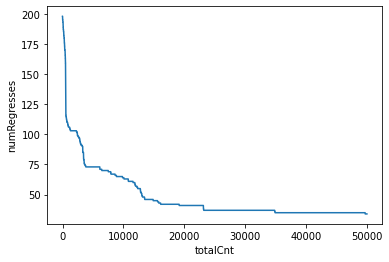

In [38]:
model.fit(trainingDf)

In [ ]:
#Run an example
buildEg = "Entity_AppDeployment;ceg_azurecsi-csi-firmware-prod-5;master_21_5_20001_0;"
queryEg = nodeTS.replace("{_buildLabel_}",buildEg)

TSegResponse = KUSTO_CLIENT_CM.execute(KUSTO_DATABASE_CM, queryEg)
TSeg = dataframe_from_result_table(TSegResponse.primary_results[0])

TSeg.to_csv(buildEg+".csv",index=False)

## Other important supplemental info:
- HS Model NoGos
- HS Local Stops
- AzD info (gdf, hs)

### HS Model NoGos

In [43]:
QUERY_HS_MODELs = """
HealthStoreGlobalStopModelResult
| where goNoGoDecision == "NoGo"
| summarize min(PreciseTimeStamp) by modelEnv, modelName, label
"""
RESPONSE = KUSTO_CLIENT_CM.execute(KUSTO_DATABASE_CM, QUERY_HS_MODELs)
dfHsNoGos = dataframe_from_result_table(RESPONSE.primary_results[0])
dfHsNoGos

,modelEnv,modelName,label,min_PreciseTimeStamp
0,Test,GlobalStopModel_OM_Log_16.26_3_3_mlsnapshot,Entity_AppDeployment;ceg_azurecompute-datapath...,2021-03-19 13:40:59.544725300+00:00
1,Test,GlobalStopModel_OM_Log_16.26_3_3_mlsnapshot,Entity_AppDeployment;ceg_azurecsi-csi-firmware...,2021-03-24 08:20:41.425414100+00:00
2,Test,GlobalStopModel_OM_Log_16.26_3_3_mlsnapshot,Entity_AppDeployment;ceg_azurecompute-compute-...,2021-03-20 15:15:12.957086600+00:00
3,Test,GlobalStopModel_OM_Log_16.26_3_3_mlsnapshot,Entity_AppDeployment;ceg_azurecsi-csi-firmware...,2021-03-19 13:40:59.546251+00:00
4,Test,GlobalStopModel_OM_0.4_Log,Entity_AppDeployment;ceg_azurenetwork-networki...,2021-03-22 15:03:15.675535600+00:00
...,...,...,...,...
2211,Test,GlobalStopModel_BuildLabel_0_6_fromHSTable_sli...,Entity_AppDeployment;ceg_azurecompute-compute-...,2021-04-20 23:20:05.969489300+00:00
2212,Prod,GlobalStopModel_BuildLabel_0_6_fromHSTable,Entity_AppDeployment;ceg_azurecompute-compute-...,2021-04-20 23:31:29.111968900+00:00
2213,Test,GlobalStopModel_BuildLabel_0_6_fromHSTable,Entity_AppDeployment;ceg_azurecompute-compute-...,2021-04-20 23:26:38.706113400+00:00
2214,Test,PercentileModel_BuildLabel_0.4_fromHSTable_thr...,Entity_AppDeployment;ceg_azurecompute-datapath...,2021-05-05 23:50:39.924261600+00:00


In [48]:
dfHsNoGosBuildLabels = dfHsNoGos[dfHsNoGos["modelName"].str.contains("BuildLabel")]

In [51]:
dfHsNoGosBuildLabels.to_csv("HsNoGosBuildLabels.csv", index=False)

### HS Local Stops

In [6]:
QUERY_LOCAL_STOPS = """
let total=RolloutHealthStatusWithBuildLabel
| summarize totalDeployedClusters=dcount(clusterName) by buildLabelPerSvc;
let regress=FormattedRegressedConditionDetailsWithBuildLabel
| where conclusion == "RegressedAndStopped"
| where conditionName in ("NodeTimeBasedDynamicHealthCheckWithPerSignalOverrideCondition", "NodeFaultConditon", "ContainerFaultCondition")
| summarize regressedClusters=dcount(clusterName) by buildLabelPerSvc;
total | join kind=leftouter regress on buildLabelPerSvc
| project buildLabelPerSvc, totalDeployedClusters, regressedClusters=iff(isempty( regressedClusters), 0, regressedClusters)
"""
RESPONSE = KUSTO_CLIENT_CM.execute(KUSTO_DATABASE_CM, QUERY_LOCAL_STOPS)
dfLocalStops = dataframe_from_result_table(RESPONSE.primary_results[0])
dfLocalStops

,buildLabelPerSvc,totalDeployedClusters,regressedClusters
0,Entity_AppDeployment;ceg_azurenetwork-networki...,2642,3
1,Entity_AppDeployment;ceg_azurenetwork-networki...,2,1
2,Entity_AppDeployment;ceg_azurenetwork-networki...,2038,1
3,Entity_AppDeployment;ceg_azurecompute-compute-...,2860,9
4,Entity_AppDeployment;ceg_azurecompute-compute-...,2935,3
...,...,...,...
846,Entity_AppDeployment;ceg_azurenetwork-networki...,1,0
847,Entity_AppDeployment;autopilot-hostos-prod;hos...,1,0
848,Entity_AppDeployment;ceg_azurestorage-storagea...,1,0
849,Entity_AppDeployment;ceg_azurenetwork-networki...,1,0


In [7]:
dfLocalStops.to_csv("LocalStops.csv", index=False)

### AzD info (gdf, hs)

In [10]:
QUERY_AzD = """
GlobalHealthStops_v2_ByQuery(ago(60d), now(), 5, "Az")
"""
RESPONSE = KUSTO_CLIENT.execute(KUSTO_DATABASE, QUERY_AzD)
dfAzD = dataframe_from_result_table(RESPONSE.primary_results[0])
dfAzD

,Source,Resource,Query,TIMESTAMP,StartDateTimeUtc,DetectionDuration,Stages,RTOs,RolloutLabels,IsFalsePositive,...,ByPassedCount,BypassApprovers,BypassDetails,BypassedClusters,Detected,IsPreDeploy,IsRTOBypass,OQuery,ManualBypassReason,ManualBypassUser
0,AzDeployHealth,GlobalOrchestration_PayloadGoNoGoDecision,entity_appdeployment;ceg_azurecompute-compute-...,2021-06-18 03:07:07.999205900+00:00,2021-06-17 17:53:43+00:00,0 days 09:13:24.999205900,[Stage],"[""2564990_14039333767665664584""]",[Entity_AppDeployment;ceg_azurecompute-compute...,0,...,0,"[""""]","[""""]",[],1,0,[],[entity_appdeployment;ceg_azurecompute-compute...,[],[]
1,AzDeployHealth,GlobalOrchestration_PayloadGoNoGoDecision,entity_appdeployment;ceg_azurecsi-csi-firmware...,2021-06-16 05:04:28.347051500+00:00,2021-06-15 19:32:45+00:00,0 days 09:31:43.347051500,"[Broad, Pilot, Canary]","[""2555561"",""2559918""]",[Entity_AppDeployment;ceg_azurecsi-csi-firmwar...,0,...,0,"[""""]","[""""]",[],1,0,[],[entity_appdeployment;ceg_azurecsi-csi-firmwar...,[],[]
2,AzDeployHealth,GlobalOrchestration_PayloadGoNoGoDecision,entity_appdeployment;ceg_azurecompute-compute-...,2021-06-15 19:52:45.818063+00:00,2021-06-15 19:09:20+00:00,0 days 00:43:25.818063,[Stage],"[""2555498_2633657051936708433""]",[Entity_AppDeployment;ceg_azurecompute-compute...,0,...,0,"[""""]","[""""]",[],1,0,[],[entity_appdeployment;ceg_azurecompute-compute...,[],[]
3,AzureComputeInsights,GlobalOrchestrationGandalfRollout,entity_appdeployment;ceg_azurecompute-compute-...,2021-06-15 03:40:41.212851+00:00,2021-06-15 03:34:56+00:00,0 days 00:05:45.212851,"[Canary, Broad]","[""2553253"",""2556520"",""2559960"",""2560583""]",[Entity_AppDeployment;ceg_azurecompute-compute...,0,...,0,"[""""]","[""""]",[],1,0,[],[entity_appdeployment;ceg_azurecompute-compute...,[],[]
4,AzDeployHealth,GlobalOrchestration_GlobalGoNoGoDecision,entity_appdeployment;ceg_azurestorage-storagea...,2021-06-09 22:39:36.260910400+00:00,2021-06-04 20:28:11+00:00,5 days 02:11:25.260910400,"[Canary, Stage]","[""2522253""]",[Entity_AppDeployment;ceg_azurestorage-storage...,0,...,0,"[""""]","[""""]",[],1,0,[],[entity_appdeployment;ceg_azurestorage-storage...,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,AzDeployHealth,GlobalOrchestration_PayloadGoNoGoDecision,entity_appdeployment;ceg_azurenetwork-networki...,2021-04-19 18:27:17.394877600+00:00,2021-04-19 07:11:40+00:00,0 days 11:15:37.394877600,"[Canary, Stage, Broad]","[""2437553"",""2441804"",""2408605"",""2412376"",""2407...",[Entity_AppDeployment;ceg_azurenetwork-network...,0,...,0,"[""""]","[""""]",[],1,0,[],[entity_appdeployment;ceg_azurenetwork-network...,[],[]
63,AzureComputeInsights,GlobalOrchestrationGandalfRollout,entity_appdeployment;ceg_azurecsi-csi-firmware...,2021-04-19 18:16:57.970287200+00:00,2021-04-17 18:16:34+00:00,2 days 00:00:23.970287200,"[Broad, Stage, Pilot]","[""2441918"",""2426650"",""2429604"",""2399686"",""2416...",[Entity_AppDeployment;ceg_azurecsi-csi-firmwar...,0,...,0,"[""""]","[""""]",[],1,0,[],[entity_appdeployment;ceg_azurecsi-csi-firmwar...,[],[]
64,AzureComputeInsights,GlobalOrchestrationGandalfRollout,entity_appdeployment;autopilot-hostos-prod;hos...,2021-04-19 18:16:13.623600800+00:00,2021-04-17 18:16:38+00:00,1 days 23:59:35.623600800,"[Canary, Pilot, Broad, Stage]","[""2453471"",""2443522"",""2537466"",""2457494"",""2480...",[Entity_AppDeployment;autopilot-hostos-prod;24...,1,...,0,"[""AME\\roaakash"",""""]","[""HostOsMitigations build wrongly correlated w...",[],1,0,[1],[entity_appdeployment;autopilot-hostos-prod;ho...,[FalseAlarm],[AME\roaakash]
65,AzDeployHealth,GlobalOrchestration_PayloadGoNoGoDecision,entity_appdeployment;ceg_azurecompute-datapath...,2021-04-19 18:15:38.008286600+00:00,2021-04-17 18:15:51+00:00,1 days 23:59:47.008286600,"[Broad, Canary, Pilot]","[""2395908""]",[Entity_AppDeployment;ceg_azurecompute-datapat...,0,...,0,"[""REDMOND\\trietle""]","[""Known issues""]",[],1,0,[1],[entity_appdeplo

In [11]:
dfAzD.to_csv("AzD.csv", index=False)

In [5]:
QUERY_snapshot = """
HealthStoreGlobalStopSnapshot
| where modelName == "PercentileModel_BuildLabel_0.4_fromHSTable_thres97_20200723"
| summarize arg_max(PreciseTimeStamp, *) by label
| project label, regressedNodeCount, totalNodeCount
"""
RESPONSE = KUSTO_CLIENT_CM.execute(KUSTO_DATABASE_CM, QUERY_snapshot)
dfSnapshot = dataframe_from_result_table(RESPONSE.primary_results[0])
dfSnapshot

,label,regressedNodeCount,totalNodeCount
0,Entity_AppDeployment;ceg_azurecompute-computec...,39,104311
1,Entity_AppDeployment;ceg_azurecompute-compute-...,4,842
2,Entity_AppDeployment;ceg_azurecompute-compute-...,51,1076
3,Entity_AppDeployment;ceg_azurecompute-compute-...,0,0
4,Entity_AppDeployment;ceg_azurecompute-compute-...,51,1076
...,...,...,...
886,Entity_AppDeployment;ceg_azurecompute-datapath...,1,211
887,Entity_AppDeployment;autopilot-onedeployhellow...,1,761
888,Entity_AppDeployment;autopilot-autopilotclient...,0,0
889,Entity_AppDeployment;ceg_azurecsi-csi-firmware...,1,281


In [6]:
dfSnapshot.to_csv("snapshot.csv", index=False)

In [9]:
QUERY_IcM = """
Incidents
| where CreateDate >= ago(20d)
| where Title contains "Outage Declared" and Title contains "Azure Disaster Recovery Drill"
| summarize min(CreateDate) by Title
"""
RESPONSE = KUSTO_CLIENT_ICM.execute(KUSTO_DATABASE_ICM, QUERY_IcM)
dfSnapshot = dataframe_from_result_table(RESPONSE.primary_results[0])
dfSnapshot

KustoServiceError: [{'error': {'code': 'Forbidden', 'message': 'Caller is not authorized to perform this action', '@type': 'Kusto.DataNode.Exceptions.UnauthorizedDatabaseAccessException', '@message': "Principal 'aaduser=3b94da75-2b3c-4f1c-8364-f28862ae82f7;72f988bf-86f1-41af-91ab-2d7cd011db47' is not authorized to access database 'IcmDataWarehouse'.", '@context': {'timestamp': '2021-06-21T20:52:34.0124080Z', 'serviceAlias': 'ICMCLUSTER', 'machineName': 'KEngine00003H', 'processName': 'Kusto.WinSvc.Svc', 'processId': 11352, 'threadId': 14284, 'appDomainName': 'Kusto.WinSvc.Svc.exe', 'clientRequestId': 'KPC.execute;84a5ec58-cd2d-4e4c-a7d8-402eb8e3e960', 'activityId': '5de456d2-9b75-4ae2-ac69-c093cc962277', 'subActivityId': '9ccbbfdd-8a8d-4ac7-ba5f-236a20e25cf9', 'activityType': 'DN.FE.ExecuteQuery', 'parentActivityId': 'c77e6130-197e-4355-b6b6-b23a9f8959b7', 'activityStack': '(Activity stack: CRID=KPC.execute;84a5ec58-cd2d-4e4c-a7d8-402eb8e3e960 ARID=5de456d2-9b75-4ae2-ac69-c093cc962277 > KD.Query.Client.ExecuteQueryAsKustoDataStream/c8002cb7-cf9b-4a50-9fbf-59476ae16413 > P.WCF.Service.ExecuteQueryInternalAsKustoDataStream..IClientServiceCommunicationContract/c77e6130-197e-4355-b6b6-b23a9f8959b7 > DN.FE.ExecuteQuery/9ccbbfdd-8a8d-4ac7-ba5f-236a20e25cf9)'}, '@permanent': True}}]